In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

2023-05-16 15:36:23.738649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:36:24.197650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/e/ML/cafa-5-protein-function-prediction


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
print("There are {} sequences in the dataset.".format(len(sequences)))

There are 142246 sequences in the dataset.


In [4]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)



In [39]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')
dfCco = df.loc[df["aspect"]=="CCO"]
uniqueTerms = dfCco["term"].unique()
termsArr = list(dfCco["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
termToken = [uniqueTermsDict[el] for el in termsArr]
dfCco["termToken"] = termToken
print(dfCco.shape)
df=dfCco

(1196017, 4)


/tmp/ipykernel_25289/428058261.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCco["termToken"] = termToken


Test for the first entry:

In [80]:
df.set_index("EntryID", inplace=True)
df.head(20)

,term,aspect,termToken
EntryID,,,
A0A021WW32,GO:0099086,CCO,0
A0A021WW32,GO:0000228,CCO,1
A0A021WW32,GO:0005622,CCO,2
A0A021WW32,GO:0043226,CCO,3
A0A021WW32,GO:0000792,CCO,4
A0A021WW32,GO:0000795,CCO,5
A0A021WW32,GO:0000785,CCO,6
A0A021WW32,GO:0043231,CCO,7
A0A021WW32,GO:0032991,CCO,8


In [16]:
%timeit df.loc["A0A021WW32"]

18.4 µs ± 75.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [17]:
df.loc["A0A021WW32"]

,term,aspect,termToken
EntryID,,,
A0A021WW32,GO:0099086,CCO,0
A0A021WW32,GO:0000228,CCO,1
A0A021WW32,GO:0005622,CCO,2
A0A021WW32,GO:0043226,CCO,3
A0A021WW32,GO:0000792,CCO,4
A0A021WW32,GO:0000795,CCO,5
A0A021WW32,GO:0000785,CCO,6
A0A021WW32,GO:0043231,CCO,7
A0A021WW32,GO:0032991,CCO,8


In [18]:
np.unique(df["aspect"].to_numpy())

array(['CCO'], dtype=object)

## GO analysis

In [19]:
item_counts = df["term"].value_counts()
print(item_counts[0:20])

GO:0005575    92912
GO:0110165    91286
GO:0005622    70785
GO:0043226    60883
GO:0043229    58315
GO:0043227    55452
GO:0005737    53193
GO:0043231    52218
GO:0005634    28932
GO:0016020    25768
GO:0071944    20467
GO:0005829    18216
GO:0005886    16738
GO:0032991    16657
GO:0043228    16145
GO:0043232    16124
GO:0031974    15696
GO:0043233    15694
GO:0070013    15688
GO:0031981    13510
Name: term, dtype: int64


In [20]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}
print(id_to_name['GO:0031981'] )

nuclear lumen


In [21]:
print(id_to_name['GO:0070013'] )
print(networkx.ancestors(graph, 'GO:0070013'))
print(networkx.descendants(graph, 'GO:0070013'))

paths = networkx.all_simple_paths(
    graph,
    source='GO:0070013',
    target=name_to_id['molecular_function']
)

for path in paths:
    print('•', ' ⟶ '.join(id_to_name[node] for node in path))

intracellular organelle lumen
{'GO:0005730', 'GO:0070860', 'GO:0000438', 'GO:0043202', 'GO:1990251', 'GO:0015030', 'GO:0101019', 'GO:0033557', 'GO:0070517', 'GO:0042645', 'GO:0061773', 'GO:0106098', 'GO:0106173', 'GO:0042382', 'GO:0120282', 'GO:0035808', 'GO:0000330', 'GO:0033276', 'GO:0030685', 'GO:0044842', 'GO:0034399', 'GO:0008023', 'GO:0016606', 'GO:0070449', 'GO:0005664', 'GO:0106055', 'GO:0001651', 'GO:0044665', 'GO:0005775', 'GO:1990483', 'GO:0032021', 'GO:0061201', 'GO:0034492', 'GO:0034423', 'GO:0016607', 'GO:0070556', 'GO:1990826', 'GO:0000118', 'GO:0097356', 'GO:0001405', 'GO:0031595', 'GO:0098566', 'GO:0031429', 'GO:0034457', 'GO:0016580', 'GO:0034469', 'GO:0062246', 'GO:0032221', 'GO:0001652', 'GO:0014803', 'GO:0043596', 'GO:0005641', 'GO:0000817', 'GO:0016604', 'GO:0008024', 'GO:0016605', 'GO:0035061', 'GO:0031601', 'GO:1904813', 'GO:0070824', 'GO:0005762', 'GO:0071339', 'GO:0031607', 'GO:0110016', 'GO:0005672', 'GO:0110145', 'GO:1990934', 'GO:0071162', 'GO:0000801', 'GO

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

dftest=df.loc["A0A021WW32"]
indices = dftest["termToken"].to_numpy()

mlb = MultiLabelBinarizer()
mlb.fit([termToken])
print(indices)
print(mlb.transform([indices]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[[1 1 1 ... 0 0 0]]


In [26]:
topGOs= item_counts
topGOs=topGOs.index.to_list()

mlb = MultiLabelBinarizer()
mlb.fit([topGOs])
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[[0 0 0 ... 0 0 0]]
2957


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 4, 5, 6, 7, 8, 9] will be ignored
  warnings.warn(


## Amino acids encoding

In [27]:
aminos_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']

In [28]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [29]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [69]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')
# dfAll.set_index("EntryID", inplace=True)
ccoEntries = dfAll.loc[dfAll["aspect"]=="CCO"]
ccoEntryIds = ccoEntries["EntryID"].unique()

# print(len(seqEntries))
print(ccoEntryIds)

ccoSequences = []
for entry in ccoEntryIds:
    ccoSequences.append(sequences[ids.index(entry)])

print(len(ccoSequences))

['A0A021WW32' 'A0A021WZA4' 'A0A023GPJ3' ... 'X6RLP6' 'X6RLR1' 'X6RM59']
92912


In [81]:
dfAll.loc[dfAll["EntryID"]=="P9WMJ9"].tail(20)
# "P9WMJ9" in ccoEntryIds

,EntryID,term,aspect
4061166,P9WMJ9,GO:0009274,CCO
4061167,P9WMJ9,GO:0005829,CCO
4061168,P9WMJ9,GO:0110165,CCO
4061169,P9WMJ9,GO:1903561,CCO
4061170,P9WMJ9,GO:0031982,CCO
4061171,P9WMJ9,GO:0030112,CCO
4061172,P9WMJ9,GO:0071944,CCO
4061173,P9WMJ9,GO:0005737,CCO
4061174,P9WMJ9,GO:0043227,CCO
4061175,P9WMJ9,GO:0005618,CCO


In [92]:
import warnings

TRAIN_VAL_SPLIT = 0.7

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(ccoSequences, ccoEntryIds))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)

#reduce data for now
sequencesShuffle = sequencesShuffle[0:10000]
idsShuffle = idsShuffle[0:10000]

#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator(padding=True):
    for i,seq in enumerate(trainSeq):
        entryId = trainIds[i]
        labelData = df.loc[entryId]
        
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()

        with warnings.catch_warnings():
            #supress the warnings for unknown classes
            warnings.simplefilter("ignore")
            y = mlb.transform([indices])
        
        arr = np.array(seq)
        mappedArr = vectMapping(arr)
        if padding:
            padWidth = maxLen - arr.size
            mappedArr = np.pad(mappedArr, (0, padWidth))
        yield mappedArr,y[0]

def generatorVal(padding=True):
    for i,seq in enumerate(valSeq):
        entryId = valIds[i]
        labelData = df.loc[entryId]
        
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()

        with warnings.catch_warnings():
            #supress the warnings for unknown classes
            warnings.simplefilter("ignore")
            y = mlb.transform([indices])
        
        arr = np.array(seq)
        mappedArr = vectMapping(arr)
        if padding:
            padWidth = maxLen - arr.size
            mappedArr = np.pad(mappedArr, (0, padWidth))
        yield mappedArr,y[0]
        

7000


In [93]:
g = generator()
test = next(g)
print("The first sample sequence: {}".format(test[0]))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample sequence: [11  1 15 ...  0  0  0]
The first sample has 21 classes


## Test data generator

In [94]:
X=[]
y=[]
for i,el in enumerate(g):
    X.append(el[0])
    y.append(el[1])
    if i ==10:
        break

In [95]:

X= np.array(X)
y= np.array(y)
print(X.shape)
print(y.shape)

(11, 35375)
(11, 2957)


## Tensorflow Classification

In [96]:
import tensorflow as tf


dataset = tf.data.Dataset.from_generator(generator, output_signature=(
         tf.TensorSpec(shape=(maxLen,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))
print(list(dataset.take(1)))

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))

[(<tf.Tensor: shape=(35375,), dtype=int32, numpy=array([11,  1, 15, ...,  0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(2957,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)]


2023-05-16 16:47:22.012762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [87]:
%load_ext tensorboard


In [98]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=100

def createModel():
    inputs = tf.keras.Input(shape=(maxLen,))
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name="embedding")(inputs)
    x=layers.GlobalAveragePooling1D()(x)
    x=layers.Reshape((EMBED_DIM,1))(x)
    x=layers.Conv1D(8, 7)(x)
    x=layers.Conv1D(8, 7)(x)
    x=layers.Conv1D(8, 7)(x)
    x=layers.Conv1D(16, 7)(x)
    x=layers.Conv1D(16, 7)(x)
    x=layers.Conv1D(16, 7, strides=2)(x)
    x=layers.Conv1D(16, 7, strides=2)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(32)(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dense(32)(x)
    x=layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedConvModel")

model = createModel()

model.summary()


Model: "embedConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 35375)]           0         
                                                                 
 embedding (Embedding)       (None, 35375, 100)        2500      
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_2 (Reshape)         (None, 100, 1)            0         
                                                                 
 conv1d_14 (Conv1D)          (None, 94, 8)             64        
                                                                 
 conv1d_15 (Conv1D)          (None, 88, 8)             456       
                                                    

In [99]:

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=200

def createRnnModel():
    inputs = tf.keras.Input(shape=(maxLen,))
    x = tf.keras.layers.Masking(0)(inputs)
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(x)

    # x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    # x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(16))(x)
    # x = layers.LSTM(32)(x)
    x = layers.Dense(16)(x)
    x = layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedRnnModel")

# model = createRnnModel()

# model.summary()

/tmp/ipykernel_25289/2623022177.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,max(plt.ylim())])


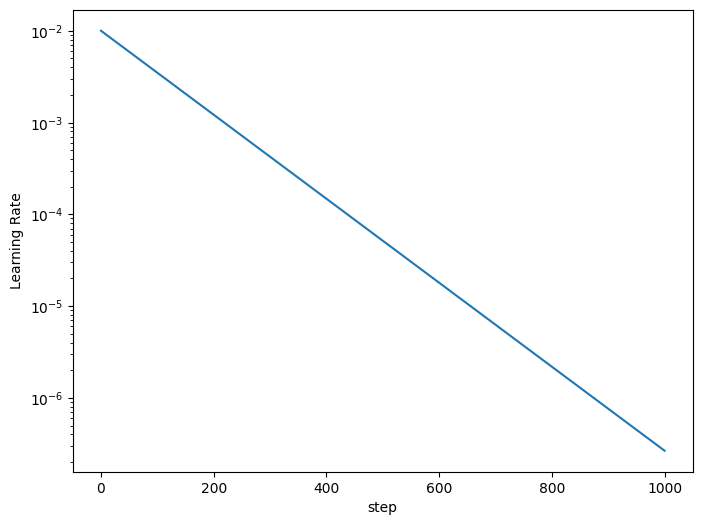

In [100]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=False)
step = np.linspace(0,1000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.yscale("log")
plt.plot(step, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('step')
_ = plt.ylabel('Learning Rate')

In [101]:
BATCH_SIZE=32
LOG_INTERVAL=5
epochs = 20
saveModel=False


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)

# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)
# print(batchedDataset.take(1))

batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"))
batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"))

# @tf.function()
def trainStep(x_batch_train, y_batch_train):
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        probs = model(x_batch_train, training=True) 

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(y_batch_train, probs)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)
    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y_batch_train, probs)
    return loss_value, grads

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(batchedDataset):

        loss_value, grads=trainStep(x_batch_train,y_batch_train)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}, Accuracy: {:.4f}, lr schedule: {:.5f}'
            print (template.format(epoch+1, step,loss_value, 
                                    train_acc_metric.result(), optimizer.learning_rate.numpy()))
            # print([tf.norm(grad, ord=2).numpy() for grad in grads])
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_val, y_batch_val in batchedDatasetVal:
        valProbs = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, valProbs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_epoch_{}_valAcc{:.3f}".format(epoch, float(val_acc))))

Num GPUs Available:  1

Start of epoch 1


2023-05-16 16:48:23.401363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/Step 0, Loss: 0.6931, Accuracy: 0.5045, lr schedule: 0.01000
Epoch 1/Step 5, Loss: 0.0526, Accuracy: 0.8777, lr schedule: 0.01000
Epoch 1/Step 10, Loss: 0.0344, Accuracy: 0.9307, lr schedule: 0.01000
Epoch 1/Step 15, Loss: 0.0162, Accuracy: 0.9508, lr schedule: 0.01000
Epoch 1/Step 20, Loss: 0.0258, Accuracy: 0.9616, lr schedule: 0.01000
Epoch 1/Step 25, Loss: 0.0155, Accuracy: 0.9684, lr schedule: 0.01000
Epoch 1/Step 30, Loss: 0.0133, Accuracy: 0.9729, lr schedule: 0.01000
Epoch 1/Step 35, Loss: 0.0138, Accuracy: 0.9762, lr schedule: 0.01000
Epoch 1/Step 40, Loss: 0.0186, Accuracy: 0.9786, lr schedule: 0.01000
Epoch 1/Step 45, Loss: 0.0165, Accuracy: 0.9806, lr schedule: 0.01000
Epoch 1/Step 50, Loss: 0.0088, Accuracy: 0.9822, lr schedule: 0.01000
Epoch 1/Step 55, Loss: 0.0124, Accuracy: 0.9835, lr schedule: 0.01000
Epoch 1/Step 60, Loss: 0.0114, Accuracy: 0.9845, lr schedule: 0.01000
Epoch 1/Step 65, Loss: 0.0113, Accuracy: 0.9855, lr schedule: 0.01000
Epoch 1/Step 70, Loss:

2023-05-16 16:48:44.722216: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-05-16 16:48:44.727691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch finished. Start validation


2023-05-16 16:48:48.452212: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Validation acc: 0.9968

Start of epoch 2
Epoch 2/Step 0, Loss: 0.0151, Accuracy: 0.9962, lr schedule: 0.01000
Epoch 2/Step 5, Loss: 0.0099, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 10, Loss: 0.0157, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 15, Loss: 0.0084, Accuracy: 0.9968, lr schedule: 0.01000
Epoch 2/Step 20, Loss: 0.0119, Accuracy: 0.9968, lr schedule: 0.01000
Epoch 2/Step 25, Loss: 0.0119, Accuracy: 0.9968, lr schedule: 0.01000
Epoch 2/Step 30, Loss: 0.0120, Accuracy: 0.9968, lr schedule: 0.01000
Epoch 2/Step 35, Loss: 0.0124, Accuracy: 0.9968, lr schedule: 0.01000
Epoch 2/Step 40, Loss: 0.0177, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 45, Loss: 0.0155, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 50, Loss: 0.0087, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 55, Loss: 0.0122, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 60, Loss: 0.0113, Accuracy: 0.9967, lr schedule: 0.01000
Epoch 2/Step 65, Loss: 0.0112, Accuracy: 0.9967, lr

In [ ]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())